## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

## Create dataset from directory

In [9]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


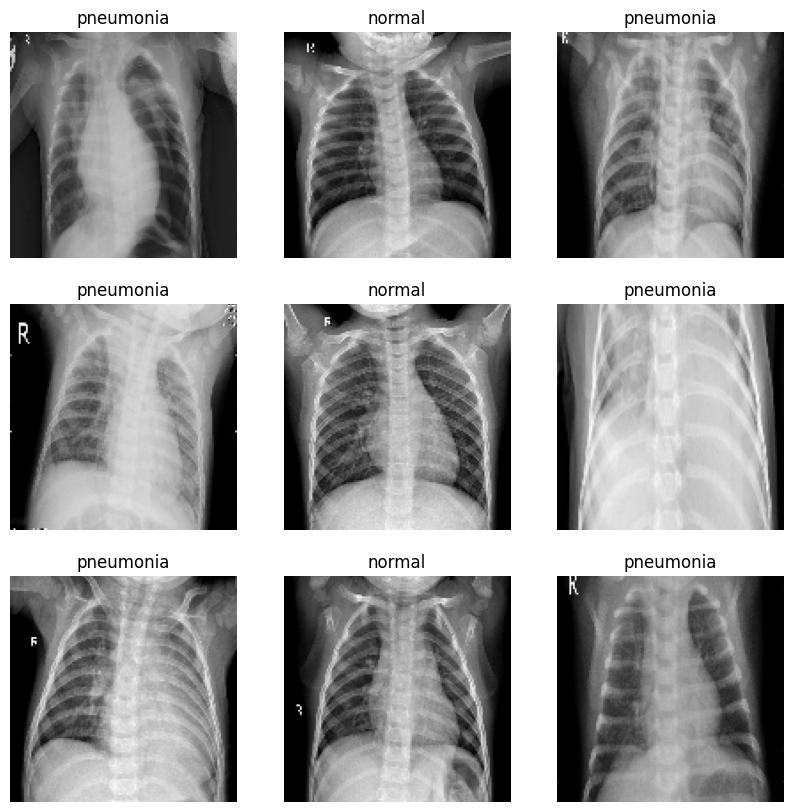

In [10]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [11]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [12]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

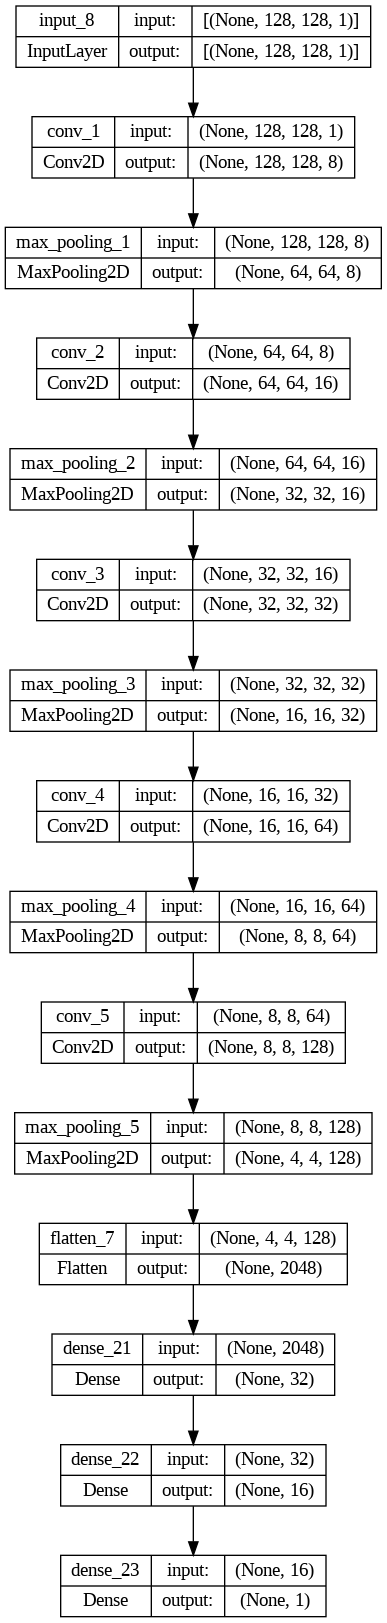

In [20]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

import tensorflow as tf

# Check if TensorFlow is using a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define CNN model
with tf.device('/GPU:0'):
    input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

    # Add convolutional layers
    x = layers.Conv2D(32, (5, 5), activation='relu')(input)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Add a dense layer
    cnn_output = layers.Dense(1, activation='sigmoid')(x)

    cnn = Model(inputs=input, outputs=cnn_output)

    # Compile CNN model
    cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])


Num GPUs Available:  0


In [18]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 442ms/step - accuracy: 0.6646 - loss: 7.4849 - val_accuracy: 0.8125 - val_loss: 0.2903
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.9383 - loss: 0.1605 - val_accuracy: 0.9375 - val_loss: 0.2362
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9608 - loss: 0.0992 - val_accuracy: 0.9375 - val_loss: 0.1649
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - accuracy: 0.9677 - loss: 0.0791 - val_accuracy: 1.0000 - val_loss: 0.0517
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.9793 - loss: 0.0507 - val_accuracy: 0.9375 - val_loss: 0.1971


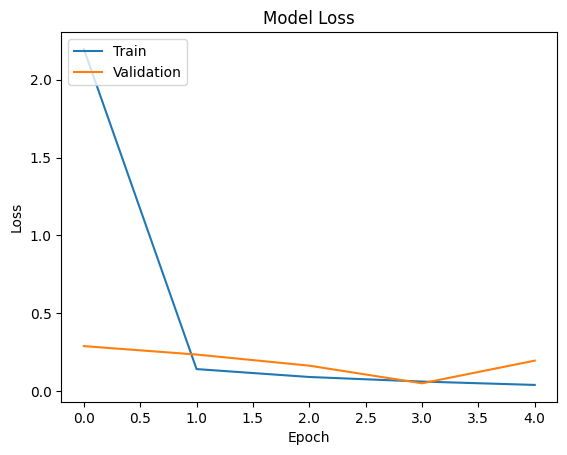

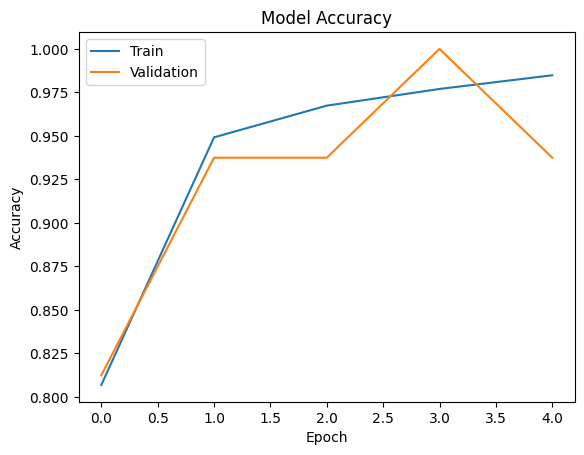

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Evaluating on validation set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


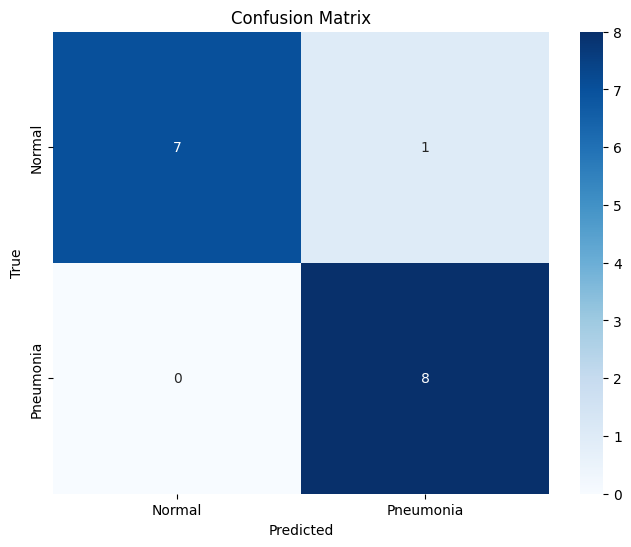

Accuracy: 0.94
F1 Score: 0.94
Evaluating on test set:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/

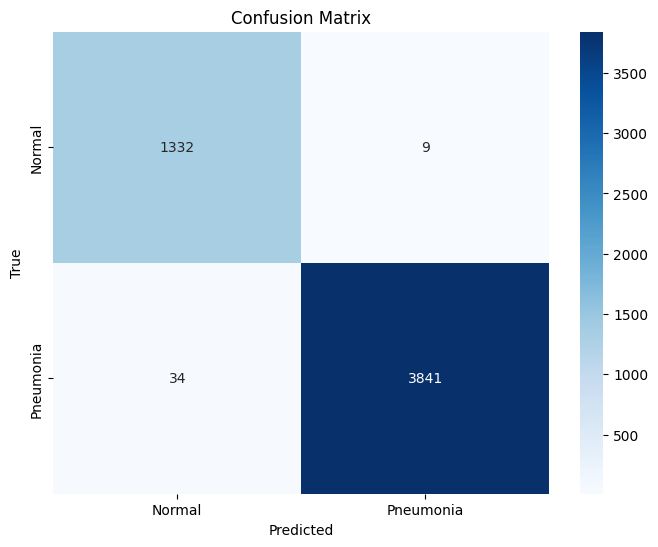

Accuracy: 0.99
F1 Score: 0.99


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import tensorflow as tf

def predict_and_evaluate(model, dataset):
    # Predict classes using the model
    predictions = []
    labels = []
    for images, label_batch in dataset:
        pred_batch = model.predict(images)
        pred_classes = (pred_batch > 0.5).astype(int)
        predictions.extend(pred_classes.flatten())
        labels.extend(label_batch.numpy().flatten().astype(int))
    
    # Convert to numpy arrays for confusion matrix and metrics computation
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate confusion matrix and metrics
    cm = confusion_matrix(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1 Score: {f1:.2f}')

# Evaluate on validation set
print("Evaluating on validation set:")
predict_and_evaluate(cnn, val_ds)

# Evaluate on test set
print("Evaluating on test set:")
predict_and_evaluate(cnn, train_ds)
